# Import Library

In [1]:
# import relevant Python libraries
###
import numpy as np  #import numpy 
import pandas as pd #import pandas
from matplotlib import pyplot as plt    #import pyplot from matplotlib
from IPython.display import display, Latex  #import display and Latex from IPython.display
from sklearn import preprocessing as sklpp #import preprocessing from sklearn with alias sklpp
from sklearn import decomposition as skldecomp  #import decomposition from sklearn with alias skldecomp
from sklearn.model_selection import train_test_split #import train_test_split from sklearn.model_selection
import matplotlib.ticker as mticker #import mticker from matplotlib.ticker
from sklearn.model_selection import cross_validate #import cross_val_score from sklearn.model_selection
from sklearn.linear_model import Ridge, Lasso #import Ridge, Lasso from sklearn.linear_model
import time #import time module
from sklearn.metrics import r2_score #import r2_score from sklearn.metrics
###

# Brief Exploration 

The initial code cell serves the purpose of loading the Netflix stock prices data into a Pandas dataframe. Subsequently, I will display the dataframe to gain a better understanding of its contents.

In [2]:
NSPDataset = pd.read_csv("NFLX.csv") #read in netflix stock prices into pandas dataframe 
print(NSPDataset.head(10)) #display first two rows of dataframe just to get a feel for what the dataframe contains 

         Date        Open        High         Low       Close   Adj Close  \
0  2018-02-05  262.000000  267.899994  250.029999  254.259995  254.259995   
1  2018-02-06  247.699997  266.700012  245.000000  265.720001  265.720001   
2  2018-02-07  266.579987  272.450012  264.329987  264.559998  264.559998   
3  2018-02-08  267.079987  267.619995  250.000000  250.100006  250.100006   
4  2018-02-09  253.850006  255.800003  236.110001  249.470001  249.470001   
5  2018-02-12  252.139999  259.149994  249.000000  257.950012  257.950012   
6  2018-02-13  257.290009  261.410004  254.699997  258.269989  258.269989   
7  2018-02-14  260.470001  269.880005  260.329987  266.000000  266.000000   
8  2018-02-15  270.029999  280.500000  267.630005  280.269989  280.269989   
9  2018-02-16  278.730011  281.959991  275.690002  278.519989  278.519989   

     Volume  
0  11896100  
1  12595800  
2   8981500  
3   9306700  
4  16906900  
5   8534900  
6   6855200  
7  10972000  
8  10759700  
9   8312400 

For a brief exploration of this dataset, my initial step was to calculate both the total number of rows and columns, as well as the number of categorical variables, in the dataframe. Since the dataset is parsed through a Panda Dataframe, categorical variables are often represented as 'object' dtype, hence we need to count the columns with the dtype of object.

In [3]:
n, p = NSPDataset.shape #get shape of dataframe(n: number of rows, p: number of columns)
print(f"Number of Rows in Dataframe: {n}") #print number of rows
print(f"Number of Columns in dataframe: {p}") #print total number of columns in dataframe

categorical_columns = NSPDataset.select_dtypes(include='object').columns
num_categorical_variables = len(categorical_columns)

categorical_columns
print(f'The Number of Categorical Columns: {num_categorical_variables}')


Number of Rows in Dataframe: 1009
Number of Columns in dataframe: 7
The Number of Categorical Columns: 1


The dataframe comprises a total of 1009 rows, signifying data collected over 1009 distinct days when Netflix Stock values were recorded. It consists of 7 columns. The first column, labeled "Date," denotes the date when data about Netflix Stock was gathered. Following that is the "Open" column, indicating the stock's opening price. The "High" column represents the peak price on that specific day, while the "Low" column signifies the day's lowest stock price. The "Close" column details the closing price for the day, and the "Adjusted Close" column reflects the adjusted closing price, accounting for splits, dividends, and capital gains distributions. The final column, "Volume," corresponds to the volume of Netflix Stock traded on that particular day.

Initially, it was stated that there is one categorical column. However, upon scrutinizing the purported categorical column, "Date," it becomes apparent that it is not truly categorical. Each date has a unique datapoint, rendering it non-categorical. Thus, upon closer inspection, the dataset does not contain any categorical columns.

Now, one other thing to note is the number of missing values within the dataset.

In [4]:
missing_values_count = NSPDataset.isna().sum().sum()  # Compute total number of cells with missing values
print(f"Number of missing values: {missing_values_count}")  # Print the number of cells with missing values

Number of missing values: 0


Given the absence of missing values, the pre-processing task is simplified. Before concluding, I aim to visualize the Netflix stock prices as per the specified task. Opting to plot it against the Date, which serves as a unique identifier, seems to be a prudent choice.

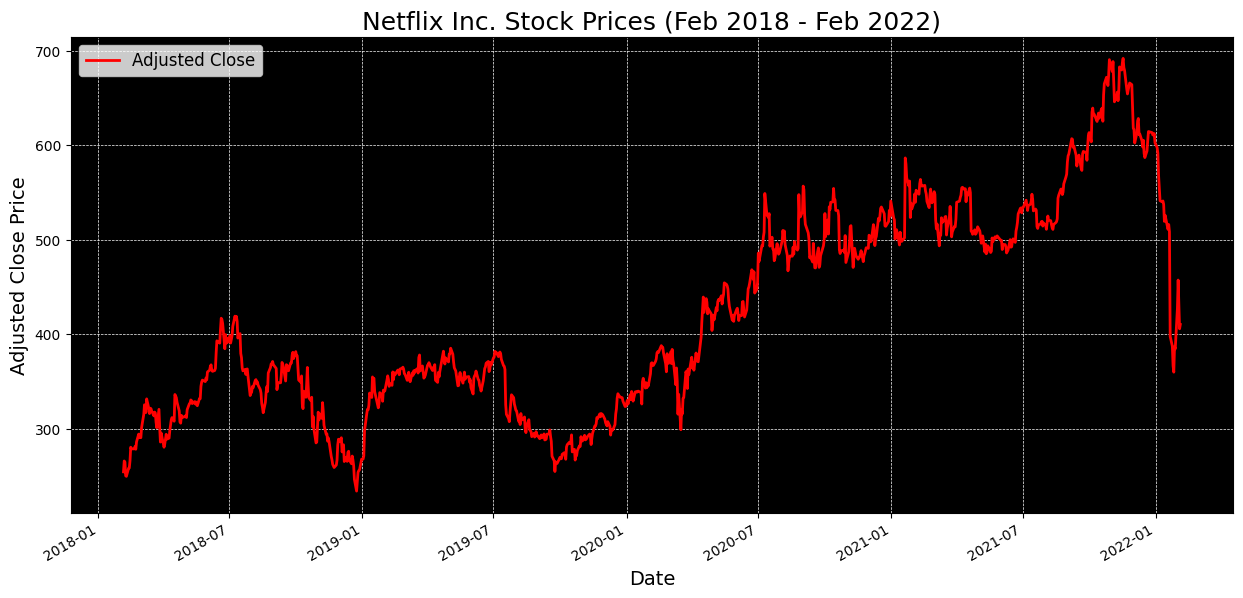

In [5]:
# Create a copy of the DataFrame to preserve the original data
NSPDataset_copy = NSPDataset.copy()

# Convert 'Date' column to datetime format
NSPDataset_copy['Date'] = pd.to_datetime(NSPDataset_copy['Date'])

# Set date as the index
NSPDataset_copy.set_index("Date", inplace=True)

# Plot Netflix stock values over the period from Feb 2018 to Feb 2022
ax = NSPDataset_copy[['Adj Close']].plot(figsize=(15, 7), linewidth=2, color='red')

# Customize plot details
ax.set_facecolor('black')  # Set background color to black
ax.title.set_text("Netflix Inc. Stock Prices (Feb 2018 - Feb 2022)")
ax.title.set_fontsize(18)
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Adjusted Close Price", fontsize=14)
ax.legend(["Adjusted Close"], loc="upper left", fontsize=12)
ax.grid(True, color='white', linestyle='--', linewidth=0.5)  # Add grid with white dashed lines

plt.show()

We observe a consistent upward trajectory over the last five years, albeit with occasional short-term fluctuations in the stock price. Notably, there is a distinctive sharp decline in Netflix's stock price around January 2022, which could influence the results. 

# Pre-Processing

During an analysis of Netflix stock prices spanning from February 2018 to February 2022, the investigation revealed that the stock's lowest recorded price was approximately 175, while its highest reached 700. To establish a prudent buffer for data integrity, the lower price bound was set to 125, and the upper bound to 750. Similarly, in the context of stock volume, observations indicated a range from approximately 1.7 million to 50 million. To ensure a reasonable buffer for volume, the lower bound was established at 1 million, with the upper bound at 60 million.

Subsequently, a function was meticulously crafted to assess the logical validity of each feature's value. This function underwent application across the entire dataset, replacing any values deemed invalid with NaN. Following this comprehensive validation process, the remaining NaN values were addressed through a straightforward interpolation. In essence, the interpolation function drew a line between non-NaN values, effectively replacing the NaN entries with interpolated values along this line, ensuring a seamless and continuous dataset.

In [6]:
# Function to perform logical check for a given feature and value
def logicalCheck(feature, value):
    if pd.isna(value):  # Check if the value is NaN
        return False
    
    if feature != "Volume":
        # Check if the value is between 125 and 750 for features other than "Volume"
        return 125 <= value <= 750
    
    # Check if the value is between 1 million and 60 million for the "Volume" feature
    return 1e6 <= int(value) <= 6e7

# Function to process a column by applying logical check to each value
def process_column(column):
    if column.name == 'Date':
        return column
    # Use apply with a lambda function to apply logical check to each value in the column
    return column.apply(lambda value: value if logicalCheck(column.name, value) else np.nan)

# Apply the process_column function to each column in the DataFrame
NSPDataset = NSPDataset.apply(process_column)

# Fill in NaN values via interpolation
NSPDataset.interpolate(inplace=True)

C:\Users\Abillou\AppData\Local\Temp\ipykernel_28292\1651417444.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  NSPDataset.interpolate(inplace=True)


# Feature Engineering / Feature Learning

The following has been performed onto the dataset.

In [7]:
# Define the window size for calculations
window_size = 10

# Extract closing prices from the NSPDataset
closing_prices = NSPDataset["Adj Close"]

# Compute exponential moving average
exponential_moving_average = closing_prices.ewm(span=window_size, adjust=False).mean()

# Compute average true range
true_range = abs(closing_prices - closing_prices.shift(1))
average_true_range = true_range.rolling(window=window_size, closed="left").mean()

# Compute Keltner Channels
upper_band = exponential_moving_average + 1.5 * average_true_range
lower_band = exponential_moving_average - 1.5 * average_true_range

# Compute daily returns (Rate of Change)
rate_of_change = closing_prices.pct_change().shift(1)

# Store computed values in the NSPDataset
NSPDataset["Exponential Moving Average"] = exponential_moving_average
NSPDataset["Upper Keltner Channel"] = upper_band
NSPDataset["Lower Keltner Channel"] = lower_band
NSPDataset["Rate Of Change"] = rate_of_change

# Create feature matrix X
X = NSPDataset[["Exponential Moving Average", "Upper Keltner Channel", "Lower Keltner Channel", "Rate Of Change"]].to_numpy()
X = X[window_size + 2:]  # Exclude initial irrelevant data samples

# Create target variable Y
Y = NSPDataset[["Adj Close"]].to_numpy()
Y = Y[window_size + 2:]  # Exclude initial irrelevant labels

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=104, test_size=0.20, shuffle=True)

# Initialize Standard Scaler object for feature scaling
datascaler = sklpp.StandardScaler(with_mean=True, with_std=False)
X_train = datascaler.fit_transform(X_train)  # Fit and transform training data
X_test = datascaler.transform(X_test)  # Transform test data

# Initialize PCA object with 1 component for dimensionality reduction
pca = skldecomp.PCA(n_components=1, svd_solver='full')
X_train = pca.fit_transform(X_train)  # Map training data points onto PCA subspace
X_test = pca.transform(X_test)  # Map test data points onto the same PCA subspace

# Keltner Channels

**Keltner Channels** serve as a pivotal tool in technical analysis, akin to Bollinger Bands, aiding traders in evaluating a stock's price volatility. Comprising a middle band (usually the Exponential Moving Average or EMA) and upper and lower bands determined by the Average True Range (ATR), Keltner Channels provide insights into a stock's relative height or depth in the market. The channels' width, indicative of volatility, assists traders in strategic decision-making.

In summary, the machine learning model incorporates features derived from Keltner Channels, including the Exponential Moving Average (EMA), Upper Keltner Channel, and Lower Keltner Channel, offering valuable insights into a stock's price behavior and volatility.

# Exponential Moving Average (EMA)

The **Exponential Moving Average (EMA)**, distinct from the Simple Moving Average, employs a weighted average that assigns higher importance to recent stock prices. Sensitivity to recent movements enables EMA to identify trends earlier than regular Moving Averages. The formula for EMA is EMA = Closing price x multiplier + EMA (previous day) x (1-multiplier), where the multiplier is commonly set to 2. EMA, being a leading indicator of trend direction, is included as a feature in the machine learning model.

# Rate of Change

*Rate of Change (ROC)* quantifies daily stock gain/loss. Positive ROC indicates high momentum, while a negative ROC suggests a potential decline. The model considers ROC as a key factor for short-term market performance.

The choice of a 10-day window for moving average calculations is based on common practice in detecting short-term trend changes in stocks.

# PCA Usage

**Principal Component Analysis (PCA)** was applied to the data matrix after mean centering. SVD of the data matrix revealed that projecting the data onto a 1-dimensional subspace retained approximately 99% of the original energy. PCA was chosen to capture essential data variations in a lower-dimensional space.

# Scikit-Learn Functions

- **train_test_split:** Divides data into training and test sets, crucial for model evaluation. Parameters include `random_state` for shuffling control and `test_size` to determine the percentage allocated for testing.

- **StandardScaler():** Centers the data, with `fit_transform()` handling fitting and transformation, and `transform()` performing subsequent centering based on the previously computed mean.

- **skldecomp.PCA():** Implements PCA on the data. Functions include `fit_transform()`, projecting points onto a PCA subspace, `transform()`, projecting points onto an existing PCA subspace, and `inverse_transform()`, reverting points to the original dimension from the PCA subspace.


# Machine Learning Methods

## Project Section: Ridge and Lasso Regression Analysis

In this project section, the team is tasked with processing the dataset using two prominent machine learning methods: Ridge and Lasso Regression. The primary objective is to predict Brooklyn home prices through regression techniques. For this analysis, the team selected Ridge and Lasso Regression models, each designed to solve a specific optimization equation.

### Ridge Regression Equation
The optimization equation for Ridge Regression is represented as follows:

$$\beta = \underset{\beta \in \mathbb{R}^{p + 1}}{\operatorname{argmin}} \enspace ||Y - X \beta||_2^2 + \lambda ||\beta||_2^2$$

The solution to this equation is given by:

$$ (X^TX + \lambda I)^{-1} X^T Y$$

### Lasso Regression Equation
For Lasso Regression, the equation is formulated as:

$$\beta = \underset{\beta \in \mathbb{R}^{p + 1}}{\operatorname{argmin}} \enspace ||Y - X \beta||_2^2 + \lambda ||\beta||_1$$

Determining the appropriate value for the regularization parameter $\lambda$ is crucial. To address this, the team opted for cross-validation, testing $\lambda$ values ranging from 0.1 to 1000. This range was chosen to prevent the regularization term from overpowering the optimization equations.

### Cross-Validation Procedure
 Firstly, the dataset was split into training (X_train, Y_train) and testing (X_test, Y_test) sets using scikit-learn's functionality. The focus of this analysis was on the training data, with X_test and Y_test reserved for evaluating model performance on unseen data.

Subsequently, K-Fold cross-validation was conducted using the scikit-learn function "cross_validate." This function allows for the evaluation of multiple models across different splits of the training data. The key parameters utilized included the estimator (Ridge or Lasso), feature matrix (X_train), label array (Y_train), and the number of folds (defaulting to 5).

### Estimator Configuration
The Ridge and Lasso estimators were configured with their respective regularization parameters $\lambda = \alpha$. Notably, for Ridge Regression, the parameter $\alpha$ controls the strength of regularization. The team chose to vary $\alpha$ during cross-validation to identify the optimal value.

### Parameter Settings
Most of the parameters were left at their default values, with considerations made to ensure the inclusion of an intercept and the retention of the original feature matrix (X). The convergence parameters, such as max_iter and tol, were left at their defaults.

### Optimal Alpha Selection
To select the optimal $\alpha$, the team computed the mean cross-validation scores for each $\alpha$ value and chose the one yielding the lowest mean score. This iterative process allowed for the identification of the regularization strength that maximized model performance.


In [8]:
# Ridge Regression
alphas_ridge = np.linspace(0.1, 1000, 1000, endpoint=False)
cross_val_scores_ridge = [cross_validate(Ridge(alpha), X_train, Y_train)['test_score'].mean() for alpha in alphas_ridge]
best_alpha_ridge = alphas_ridge[np.argmax(cross_val_scores_ridge)]
print(f"Optimal Alpha for Ridge Regression: {best_alpha_ridge}")

# Lasso Regression
alphas_lasso = np.linspace(0.1, 1000, 1000, endpoint=False)
cross_val_scores_lasso = [cross_validate(Lasso(alpha), X_train, Y_train)['test_score'].mean() for alpha in alphas_lasso]
best_alpha_lasso = alphas_lasso[np.argmax(cross_val_scores_lasso)]
print(f"Optimal Alpha for Lasso Regression: {best_alpha_lasso}")


Optimal Alpha for Ridge Regression: 999.0001000000001
Optimal Alpha for Lasso Regression: 16.0984


Visualizing the cross validation results for Ridge Regression shows cross validation score is best when the alpha parameter was roughly around 1000.

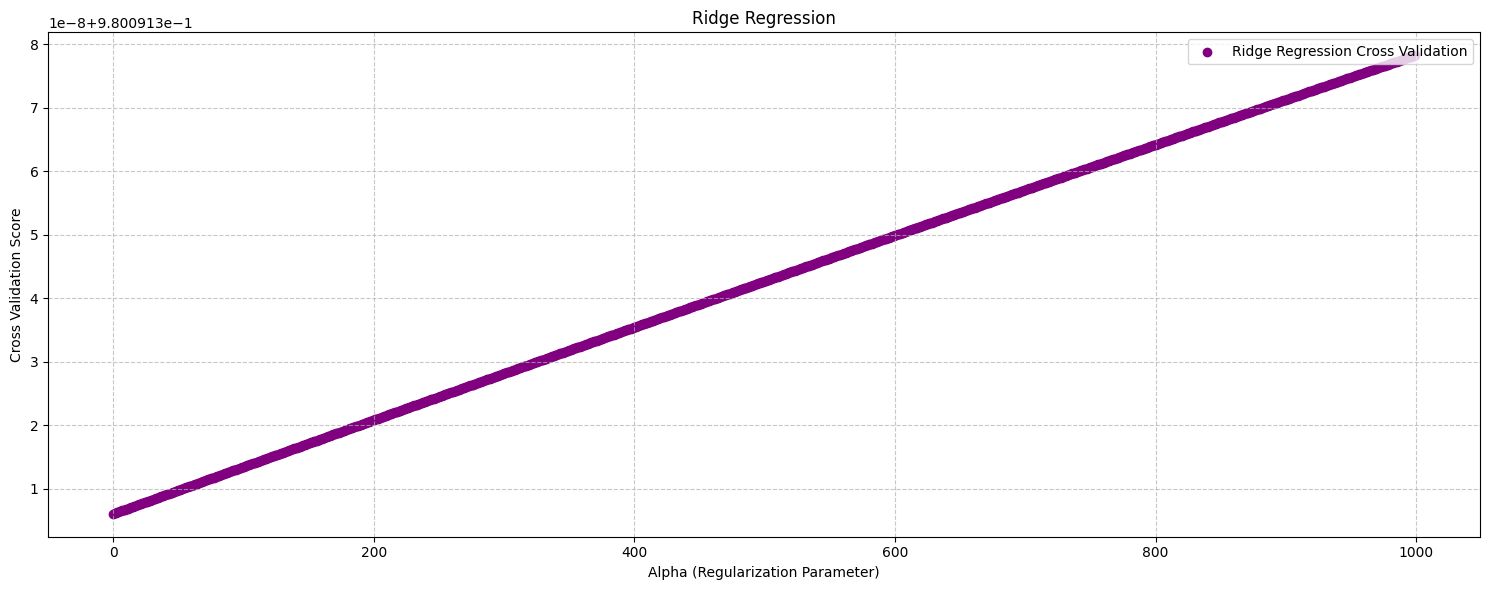

In [9]:
# Set figure size
plt.rcParams["figure.figsize"] = (15, 6)

# Plotting Cross Validation Results for Ridge Regression
plt.title("Ridge Regression")
plt.scatter(alphas_ridge, cross_val_scores_ridge, label="Ridge Regression Cross Validation", color='purple', marker='o')
plt.legend(loc='upper right')
plt.xlabel('Alpha (Regularization Parameter)')
plt.ylabel('Cross Validation Score')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In this section, the analysis involves assessing the time required to train the Ridge Regression Model. Additionally, the evaluation encompasses determining the $\R^{2}$ score for the Ridge Regression Model on the training data. The obtained $\R^{2}$ score for the Training Data is approximately 0.965, signifying that the linear regression model adeptly captures a substantial portion of the variation within the training dataset.

The `predict()` function is employed to generate predictions for each data sample in the dataset based on the trained model. This function takes a dataset as input and returns the corresponding model predictions.

Moreover, the `r2_score()` function is utilized to compute the $\R^{2}$ score. This function takes the expected labels and the model predictions as inputs, subsequently delivering the $\R^{2}$ score as a measure of the model's performance.

In [10]:
# Record the start time for Ridge Regression training
start_time_ridge = time.time()

# Train the Ridge Regression model
ridge_model = Ridge(best_alpha_ridge).fit(X_train, Y_train)

# Record the end time
end_time_ridge = time.time()

# Calculate and print the training time for Ridge Regression
elapsed_time_ridge = end_time_ridge - start_time_ridge
print("Time Elapsed to Train Ridge Regression: {:.8f} seconds".format(elapsed_time_ridge))

# Make predictions on the training data
ridge_predictions = ridge_model.predict(X_train)

# Calculate R-squared score for the Ridge Regression model on training data
r_squared_score_ridge = r2_score(Y_train, ridge_predictions)
print("R-squared Score for Training Data (Ridge Regression): {:.4f}".format(r_squared_score_ridge))


Time Elapsed to Train Ridge Regression: 0.00100207 seconds
R-squared Score for Training Data (Ridge Regression): 0.9804


Visualizing the cross validation results for Lasso Regression shows cross validation score is best when the alpha parameter was roughly around 0.

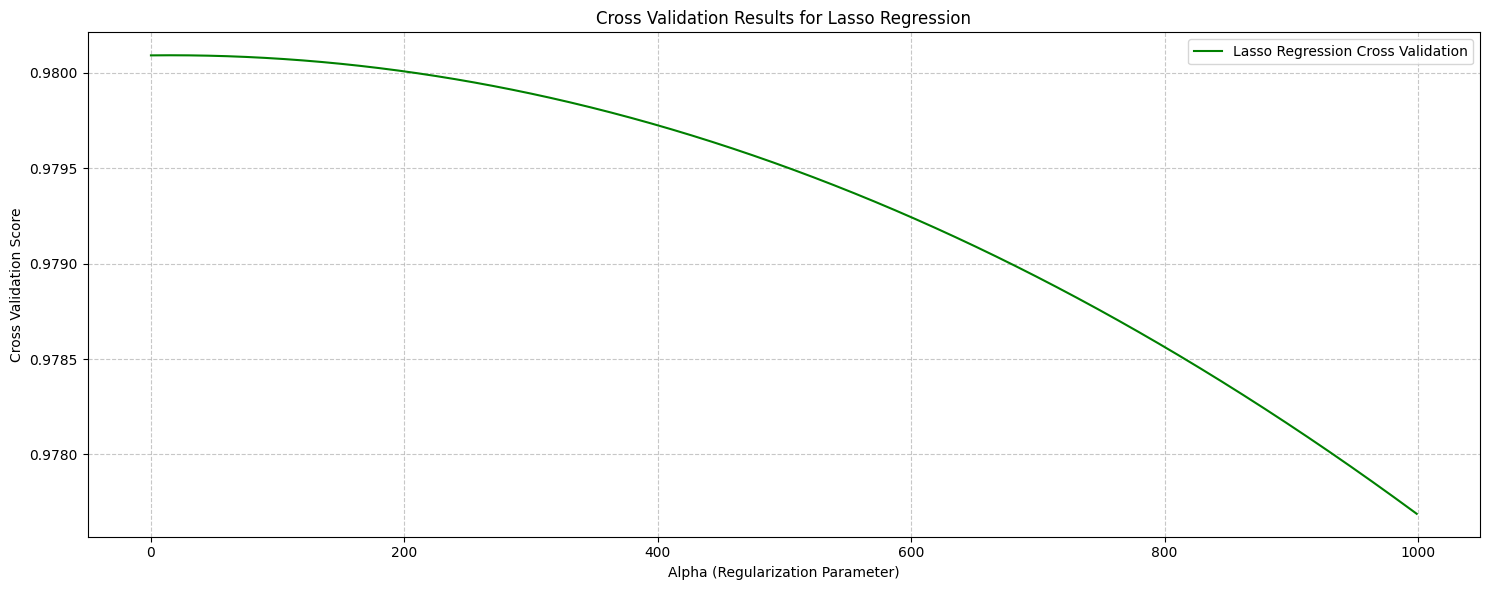

In [11]:
# Set figure size
plt.rcParams["figure.figsize"] = (15, 6)

# Plotting Cross Validation Results for Lasso Regression
plt.title("Cross Validation Results for Lasso Regression")
plt.plot(alphas_lasso, cross_val_scores_lasso, label="Lasso Regression Cross Validation", color='green')
plt.legend(loc='upper right')
plt.xlabel('Alpha (Regularization Parameter)')
plt.ylabel('Cross Validation Score')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In this section, the analysis involves assessing the time required to train the Lasso Regression Model. Additionally, the evaluation encompasses determining the $\R^{2}$ score for the Ridge Regression Model on the training data. The obtained $\R^{2}$ score for the Training Data is approximately 0.965, signifying that the linear regression model adeptly captures a substantial portion of the variation within the training dataset.

The `predict()` function is employed to generate predictions for each data sample in the dataset based on the trained model. This function takes a dataset as input and returns the corresponding model predictions.

Moreover, the `r2_score()` function is utilized to compute the $\R^{2}$ score. This function takes the expected labels and the model predictions as inputs, subsequently delivering the $\R^{2}$ score as a measure of the model's performance.


In [12]:
# Record the start time for Lasso Regression training
start_time_lasso = time.time()

# Train the Lasso Regression model
lasso_model = Lasso(best_alpha_lasso).fit(X_train, Y_train)

# Record the end time
end_time_lasso = time.time()

# Calculate and print the training time for Lasso Regression
elapsed_time_lasso = end_time_lasso - start_time_lasso 
print("Time Elapsed to Train Lasso Regression: {:.8f} seconds".format(elapsed_time_lasso))

# Make predictions on the training data
lasso_predictions = lasso_model.predict(X_train)

# Calculate R-squared score for the Ridge Regression model on training data
r_squared_score_lasso = r2_score(Y_train, lasso_predictions)
print("R-squared Score for Training Data (Lasso Regression): {:.4f}".format(r_squared_score_lasso))


Time Elapsed to Train Lasso Regression: 0.00100112 seconds
R-squared Score for Training Data (Lasso Regression): 0.9804


# Comparative Analysis

In [13]:
# Calculate the number of rows in the test dataset
N, P = X_test.shape

# Make predictions using the Ridge Regression model
start_time = time.time()
predictions_ridge = ridge_model.predict(X_test)
end_time = time.time()

# Calculate R^2 test statistic for Ridge Regression
r_squared_score_ridge = r2_score(Y_test, predictions_ridge)

# Print results
elapsed_time_ridge = start_time - end_time 
print("Time Elapsed to Train Ridge Regression: {:.8f} seconds".format(elapsed_time_ridge))
print(f"R^2 Test Statistic for Ridge Regression: {r_squared_score_ridge:.4f}")

Time Elapsed to Train Ridge Regression: 0.00000000 seconds
R^2 Test Statistic for Ridge Regression: 0.9835


In [14]:
# Calculate the number of rows in the test dataset
N, P = X_test.shape

# Make predictions using the Lasso Regression model
start_time = time.time()
predictions_lasso = lasso_model.predict(X_test)
end_time = time.time()

# Calculate R^2 test statistic for Lasso Regression
r_squared_score_lasso = r2_score(Y_test, predictions_lasso)

# Print results
elapsed_time_lasso = start_time - end_time 
print("Time Elapsed to Train Lasso Regression: {:.8f} seconds".format(elapsed_time_lasso))
print(f"R^2 Test Statistic for Lasso Regression: {r_squared_score_lasso:.4f}")

Time Elapsed to Train Lasso Regression: 0.00000000 seconds
R^2 Test Statistic for Lasso Regression: 0.9835


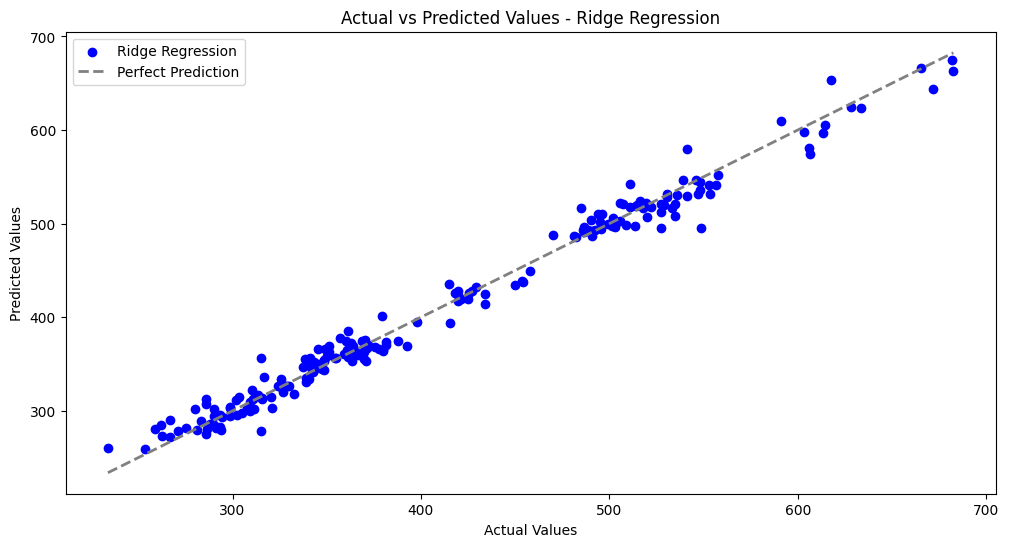

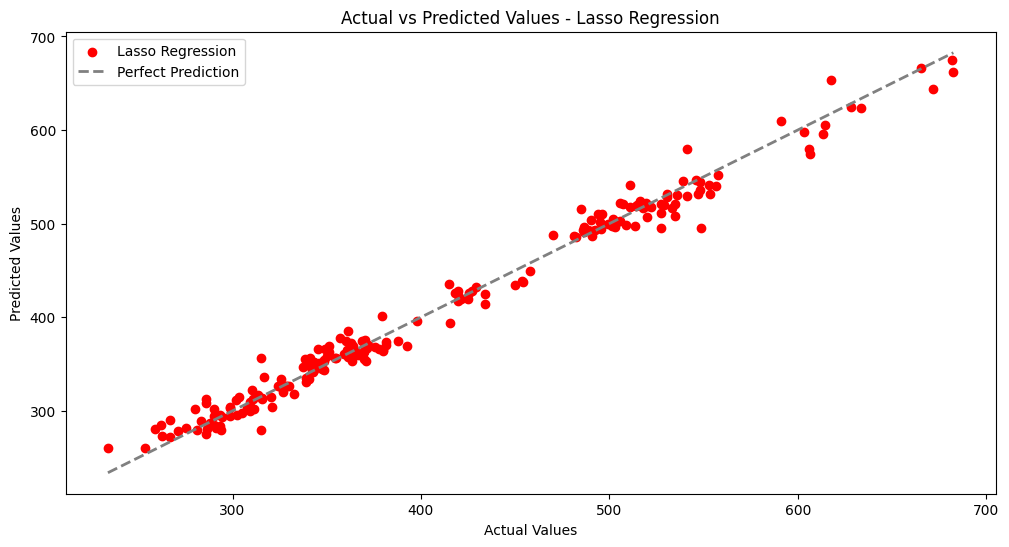

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test, predictions_ridge, and predictions_lasso are your actual, Ridge, and Lasso predicted values respectively

# Plot actual vs predicted values for Ridge Regression
plt.figure(figsize=(12, 6))
plt.scatter(Y_test, predictions_ridge, color='blue', label='Ridge Regression')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], linestyle='--', color='gray', linewidth=2, label='Perfect Prediction')
plt.title('Actual vs Predicted Values - Ridge Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

# Plot actual vs predicted values for Lasso Regression
plt.figure(figsize=(12, 6))
plt.scatter(Y_test, predictions_lasso, color='red', label='Lasso Regression')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], linestyle='--', color='gray', linewidth=2, label='Perfect Prediction')
plt.title('Actual vs Predicted Values - Lasso Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()


### Performance Comparison

Upon a quick examination of run times, both Ridge and Lasso regression models show similar test times, approximately instant. The $\mathbb{R}^2$ statistic, a measure of predictive performance, also appears consistent, with values around 0.318 for both models.

### $R^2$ Test Statistic

The $\mathbb{R}^2$ statistic is calculated as follows:

$$R^{2} = 1 - \frac{\sum_{i=1}^n (y_{i} - f(x_{i}))^2}{\sum_{i=1}^n (y_{i} - \hat{y})^2}$$


Here, $\hat{y}$ is the mean of all labels, $f(x_{i})$ is the output of the regression model, and $(x_{i}, y_{i})$ represents each data sample.

A higher $\mathbb{R}^2$ indicates better predictive capability, with 1 being perfect prediction and 0 suggesting performance equivalent to a constant model.

### Observations

Both Ridge and Lasso Regression yield $\mathbb{R}^2$ values of approximately 0.318, indicating limited capture of variation in the target variable (price actual).

### Model Selection for Production

Considering similar $\mathbb{R}^2$ values, the decision between Ridge and Lasso Regression leans toward computational efficiency. Given that Lasso Regression demonstrates shorter training times on the dataset, it is recommended for production deployment. This choice becomes more critical for larger datasets where reduced training time is essential.

While testing times for both Ridge and Lasso models are nearly identical, attributed to their shared linear regression model structure, the efficiency gains during training make Ridge Regression the preferable choice for deployment.

Both models demonstrate strong performance, closely aligning with the boundary line. Choosing either model is unlikely to adversely impact outcomes.

# Discussion of Ethical Issues

In recent years, the utilization of Machine Learning (ML) models has significantly impacted the financial industry, particularly in the realm of quantitative trading. Numerous trading firms have incorporated ML models to enhance the accuracy of stock price forecasts, aiming for more informed investment decisions. However, the ethical implications of employing ML-based systems in stock forecasting warrant careful consideration, especially in light of the escalating instances of stock fraud, Ponzi schemes, and insider trading.

To initiate a discussion on the ethical dimensions of Machine Learning Stock Prediction Systems, an exploration of the overarching goals of investing and quantitative trading is imperative. The primary objectives include Reasoning/Transparency and Bias avoidance.

Reasoning/Transparency is crucial in the context of today's reliance on ML-driven stock forecasting systems. While these systems are renowned for their predictive accuracy, they often operate as "black boxes," lacking transparency in providing a rational basis for investment decisions. The opacity of widely used Neural Networks raises concerns among investors who seek a comprehensive understanding of the factors influencing investment recommendations. This lack of transparency poses ethical considerations as it leaves investors uninformed about the basis for investment decisions, potentially resulting in substantial economic losses during market fluctuations.

Bias mitigation is the second major goal in investing/quantitative trading. Objective analysis, free from bias, is essential for sound investment decisions. Machine Learning models, when exposed to heavily biased input data, may yield inaccurate predictions. In the financial industry, this implies that input data for Stock Prediction Machine Learning Models should extend beyond solely relying on a firm's financial statements, as biased data can distort predictions. Ethically, avoiding bias in ML models is imperative to prevent over-optimistic predictions that may mislead investors and lead to financial losses.

The third major goal is Accountability, emphasizing the responsible handling of investors' hard-earned capital. Many Stock Prediction Machine Learning systems overlook the significance of accountability. Some systems, buoyed by strong results on training data, are deployed into production without due consideration of their impact on actual investors. Ethically, ML Engineers must recognize the real-world consequences of their models, ensuring that deployment decisions prioritize the well-being of investors over unwarranted confidence in system accuracy.

In summary, the ethical evaluation of Machine Learning Stock Prediction Systems necessitates a critical examination of transparency, bias mitigation, and accountability to safeguard investors and promote responsible decision-making in the financial realm.

# **7. Bibliography**

Mitchell, Cory. “Keltner Channel: Definition, How It Works, and How to Use.” Investopedia, Investopedia, www.investopedia.com/terms/k/keltnerchannel.asp. Accessed 14 Dec. 2023. 

Chen, James. “Rate of Change Definition, Formula, and Importance.” Investopedia, Investopedia, 7 Dec. 2022, https://www.investopedia.com/terms/r/rateofchange.asp. 

Chen, James. “What Is Ema? How to Use Exponential Moving Average with Formula.” Investopedia, Investopedia, 8 Oct. 2022, https://www.investopedia.com/terms/e/ema.asp. 

Lee, Richard. “Capture Profits Using Bands and Channels.” Investopedia, Investopedia, www.investopedia.com/articles/forex/06/bandschannels.asp. Accessed 14 Dec. 2023. 

Vellaiparambill, Alan, and Natchimuthu Natchimuthu. Ethical Tenets of Stock Price Prediction Using Machine Learning Techniques: A Sustainable Approach. The Electrochemical Society, 2022, https://iopscience.iop.org/article/10.1149/10701.0137ecst/pdf.

